In [1]:
import numpy as np
import struct
import ctypes as ct
import matplotlib.pylab as plt

MAGIC=b'VCA DATA\x01\x00\x00U' #This sequence is the beginning of each file
MAGIC_SIZE=12
DEBUG=False

class DektakItem:
    
    def __init__(self, name=None, data_type=None, data=None):
        self.name=name
        self.data_type=data_type
        self.data=data

class DektakLoad:
    data_types=dict({'DEKTAK_MATRIX'       : 0x00, # Too lazy to assign an actual type id?
                    'DEKTAK_BOOLEAN'      : 0x01, # Takes value 0 and 1 */
                    'DEKTAK_SINT32'       : 0x06,
                    'DEKTAK_UINT32'       : 0x07,
                    'DEKTAK_SINT64'       : 0x0a,
                    'DEKTAK_UINT64'       : 0x0b,
                    'DEKTAK_FLOAT'        : 0x0c, # Single precision float */
                    'DEKTAK_DOUBLE'       : 0x0d, # Double precision float */
                    'DEKTAK_TYPE_ID'      : 0x0e, # Compound type holding some kind of type id */
                    'DEKTAK_STRING'       : 0x12, # Free-form string value */
                    'DEKTAK_QUANTITY'     : 0x13, # Value with units (compound type) */
                    'DEKTAK_TIME_STAMP'   : 0x15, # Datetime (string/9-byte binary) */
                    'DEKTAK_UNITS'        : 0x18, # Units (compound type) */
                    'DEKTAK_DOUBLE_ARRAY' : 0x40, # Raw data array, in XML Base64-encoded */
                    'DEKTAK_STRING_LIST'  : 0x42, # List of Str */
                    'DEKTAK_ANON_MATRIX'  : 0x45, # Like DEKTAK_MATRIX, but with no name. */
                    'DEKTAK_RAW_DATA'     : 0x46, # Parent/wrapper tag of raw data */
                    'DEKTAK_RAW_DATA_2D'  : 0x47, # Parent/wrapper tag of raw data */
                    'DEKTAK_POS_RAW_DATA' : 0x7c, # Base64-encoded positions, not sure how
                                                  # it differs from 64 */
                    'DEKTAK_CONTAINER'    : 0x7d, # General nested data structure */
                    'DEKTAK_TERMINATOR'   : 0x7f # Always the last item.
                                                   #Usually a couple of 0xff bytes inside. */
                                                   })
    
    def __init__(self,filename):
        self.filename=filename
        self.items=[]
        self.reading_2D=False
        self.reading_1D=False
        self.terminator=False
        self.current_count=0
        with open(self.filename, 'rb') as f:
            f.seek(0,2)
            self.eof=f.tell()
            f.seek(0,0)
        self.read()
    
    def read_varlen(self, f):
        length=int.from_bytes(f.read(1),"big")
        if length==1:
            return int.from_bytes(f.read(1),"big")
        elif length==2:
            return int.from_bytes(f.read(2),"big")
        elif length==4:
            return int.from_bytes(f.read(4),"big")
        else:
            print('The varlength format was not respected')
            return -1
    
    def read_structured(self, item, f):
        self.read_varlen(f)
        item.data=dict()
        item.data['items']=[]
        last_item=self.read_item(f)
        while(not self.terminator and last_item is not None):
            item.data['items'].append(last_item)
            last_item=self.read_item(f)
        self.terminator=False
        return item
    
    def read_name(self, f):
        data=f.read(4)
        length=struct.unpack('i',data)[0]
        return f.read(length).decode()
            

    
    def read_item(self, f):
        if f.tell()==self.eof:
            return None
        
        
        item=DektakItem()
        item.name=self.read_name(f)
        datatype=f.read(1)
        if DEBUG:
            print('the datatype of this item is: {:}'.format(datatype))
        item.data_type=int.from_bytes(datatype, "big")
        if item.data_type==DektakLoad.data_types['DEKTAK_BOOLEAN']:
            item.data=f.read(1)
        elif item.data_type==DektakLoad.data_types['DEKTAK_SINT32']:
            item.data=struct.unpack('I',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_UINT32']:
            item.data=struct.unpack('I',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_SINT64']:
            data=f.read(8)
            item.data=struct.unpack('Q',data)[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_UINT64']:
            item.data=struct.unpack('Q',f.read(8))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_FLOAT']:
            item.data=struct.unpack('f',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_DOUBLE']:
            item.data=struct.unpack('d',f.read(8))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_TIME_STAMP']:
            item.data=f.read(9)
        elif item.data_type==DektakLoad.data_types['DEKTAK_STRING']:
            length=self.read_varlen(f)
            item.data=f.read(length).decode()
        elif item.data_type==DektakLoad.data_types['DEKTAK_STRING_LIST']:
            item.data=dict()
            item.data['datatype']=self.read_name(f)
            length=self.read_varlen(f)
            item.data['strings']=[self.read_name(f)]
        elif item.data_type==DektakLoad.data_types['DEKTAK_DOUBLE_ARRAY']:
            item.data=dict()
            item.data['datatype']=self.read_name(f)
            f.read(8)
            item.data['data']=np.frombuffer(f.read(self.current_count*8),
                     dtype=float)
        elif item.data_type==DektakLoad.data_types['DEKTAK_UNITS']:
            item.data=dict()
            item.data['length']=self.read_varlen(f)
            item.data['name']=self.read_name(f)
            item.data['symbol']=self.read_name(f)
            item.data['value']=struct.unpack('d',f.read(8))[0]
            f.read(12)
        elif item.data_type==DektakLoad.data_types['DEKTAK_QUANTITY']:
            item.data=dict()
            item.data['length']=self.read_varlen(f)
            item.data['value']=struct.unpack('d',f.read(8))[0]
            item.data['name']=self.read_name(f)
            item.data['symbol']=self.read_name(f)
            if len(item.data['name'])>0:
                f.read(20)
            else:
                f.read(16)
        elif item.data_type==DektakLoad.data_types['DEKTAK_TERMINATOR']:
            self.reading_2D=False
            self.reading_1D=False
            self.terminator=True
            item.data=f.read(2)
        elif item.data_type==DektakLoad.data_types['DEKTAK_TYPE_ID']:
            item.data=dict()
            item.data['name']=self.read_name(f)
            length=self.read_varlen(f)
            item.data['value']=int.from_bytes(f.read(length), 'little')
        elif item.data_type==DektakLoad.data_types['DEKTAK_POS_RAW_DATA']:
            if self.reading_2D:
                item.data=dict()
                item.data['name']=self.read_name(f)
                item.data['length']=self.read_varlen(f)
                item.data['value_x']=struct.unpack('d',f.read(8))[0]
                item.data['unit_name_x']=self.read_name(f)
                item.data['unit_symbol_x']=self.read_name(f)
                item.data['divisor_x']=struct.unpack('d',f.read(8))[0]
                f.read(12)
                item.data['value_y']=struct.unpack('d',f.read(8))[0]
                item.data['unit_name_y']=self.read_name(f)
                item.data['unit_symbol_y']=self.read_name(f)
                item.data['divisor_y']=struct.unpack('d',f.read(8))[0]
                f.read(12)
            elif self.reading_1D:
                item.data=dict()
                item.data['name']=self.read_name(f)
                item.data['length']=self.read_varlen(f)
                item.data['unit_name']=self.read_name(f)
                item.data['unit_symbol']=self.read_name(f)
                item.data['divisor']=struct.unpack('d',f.read(8))[0]
                f.read(12)
                item.data['count']=struct.unpack('Q',f.read(8))[0]
                self.current_count=item.data['count']
                N=item.data['length']
                N=item.data['count']
                item.data['data']=np.frombuffer(f.read(N*8), dtype=float)
                
        elif item.data_type==DektakLoad.data_types['DEKTAK_ANON_MATRIX']:
            item.data=dict()
            item.data['name']=self.read_name(f)
            item.data['size']=self.read_varlen(f)
            item.data['yres']=struct.unpack('I',f.read(4))[0]
            item.data['xres']=struct.unpack('I',f.read(4))[0]
            if item.data['size']<2*ct.sizeof(ct.c_uint32):
                print('PROBLEM')
            item.data['size']-=2*ct.sizeof(ct.c_uint32)
            N=item.data['xres']*item.data['yres']
            data=f.read(4*N)
            item.data['data']=np.reshape(np.frombuffer(data,
                     dtype="float32"), (item.data['yres'],
                                    item.data['xres']))
            
            
        elif item.data_type==DektakLoad.data_types['DEKTAK_MATRIX']:
            item.data=dict()
            item.data['name']=f.read(4)
            item.data['size']=self.read_varlen(f)
            item.data['xres']=struct.unpack('I',f.read(4))[0]
            item.data['yres']=struct.unpack('I',f.read(4))[0]
            if item.data['size']<2*ct.sizeof(ct.c_uint32):
                print('PROBLEM')
            item.data['size']-=2*ct.sizeof(ct.c_uint32)
        elif item.data_type==DektakLoad.data_types['DEKTAK_CONTAINER']:
            if item.name=='1D_Data':
                self.reading_1D=True
            elif item.name=='2D_Data':
                self.reading_2D=True
            item=self.read_structured(item, f)
        elif item.data_type==DektakLoad.data_types['DEKTAK_RAW_DATA']:
            item=self.read_structured(item, f)
        elif item.data_type==DektakLoad.data_types['DEKTAK_RAW_DATA_2D']:
            item=self.read_structured(item, f)
        else:
            print('unknown data_type')
            print(f.read(100))
            print(item.data_type)
        if DEBUG:
            print('{:},{:},{:}===>>>>{:} ; {:}'.format(item.data_type,
              f.tell(), datatype, item.name, item.data))
        return item
            
        
    def read(self):
        with open(self.filename, 'rb') as f:
            while(f.tell()!=MAGIC_SIZE):
                f.read(1)
            while(len(self.items)<10):
                item=self.read_item(f)
                self.items.append(item)
    
    def get_data_1D(self):
        x,y,scale, divisor=None, None, None, None
        for item in self.items:
            if item is not None:
                if item.name=='1D_Data':
                    break
        subitem=None
        for k in item.data['items']:
            if k.name=='Raw':
                subitem=k
                break
        if subitem is not None:
            for k in subitem.data['items']:
                if k.name=='PositionFunction':
                    x=k.data['data']
                    divisor=k.data['divisor']
                elif k.name=='Array':
                    y=k.data['data']
                elif k.name=='DataScale':
                    scale=k.data['value']
            return x/divisor, y*scale/divisor
        else:
            return None, None
    
    def get_data_2D(self, plot=True):
        for item in self.items:
            if item is not None:
                if item.name=='2D_Data':
                    break
        subitem=None
        for k in item.data['items']:
            if k.name=='Raw':
                subitem=k
                break
        if subitem is not None:
            divisor=1
            for mat in subitem.data['items']:
                if mat.name=='Matrix':
                    break
            for scale in subitem.data['items']:
                if scale.name=='DataScale':
                    if scale.data['name']=='Micrometer':
                        divisor=1e6
                    break
            for dim1 in subitem.data['items']:
                if dim1.name=='Dimension1Extent':
                    break
            for dim2 in subitem.data['items']:
                if dim2.name=='Dimension2Extent':
                    break
            for subsubitem in subitem.data['items']:
                if subsubitem.name=='PositionFunction':
                    symbol_x, symbol_y=(subsubitem.data['unit_symbol_x'],
                                        subsubitem.data['unit_symbol_y'])
                    break
            if plot:
                teste = mat.data['data']
                plt.imshow(mat.data['data']*scale.data['value'],
                           extent=[0,dim2.data['value'],
                                   0,dim1.data['value']])
                plt.xlabel(symbol_x)
                plt.ylabel(symbol_y)
            zs=mat.data['data']*scale.data['value']/divisor
            xs=np.linspace(0, dim1.data['value'],
                           np.shape(mat.data['data'])[1])
            ys=np.linspace(0, dim2.data['value'],
                           np.shape(mat.data['data'])[0])
            return (xs, ys, zs)
        else:
            return None, None, None
    
    def get_metadata(self):
        for item in self.items:
            if item is not None:
                if item.name=='MetaData':
                    break
        res=dict()
        for k in item.data['items']:
            if not isinstance(k.data, dict):
                res[k.name]=k.data
            else:
                res[k.name]=dict()
                for child in k.data['items']:
                    res[k.name][child.name]=child.data
        return res

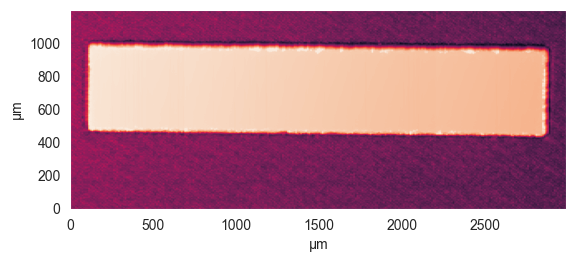

In [17]:
loader = DektakLoad('T1C/T1C_90graus_Negativo.OPDx')
x,y,z = loader.get_data_2D()


In [80]:
import pandas as pd
import seaborn as sns    

pontos = 125
corte = 150

sns.set_style('dark')
sns.set_palette('tab10')


15.912675


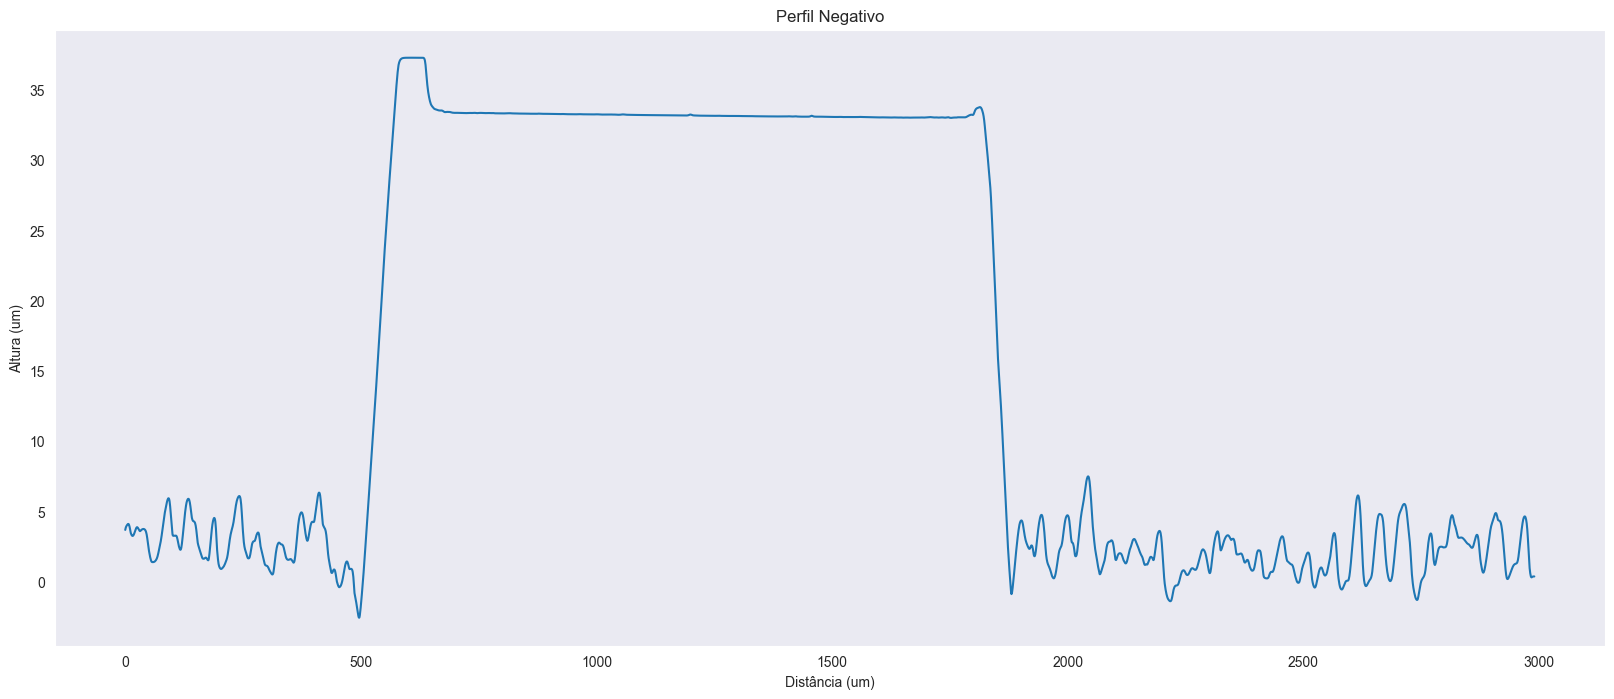

In [19]:
altura = pd.Series()
for i in range(len(y)):
    altura[i] = ((z[i][corte]*1000000))
print(altura.mean())
if altura.mean() > 0:
    Perfil = "Negativo"
else:
    Perfil = "Positivo"

ax = sns.lineplot(y= altura, x = y)
ax.figure.set_size_inches(20,8)
ax.set_title("Perfil %s"%Perfil)
ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")


"""Exibir um ponto aleatório na curva


rng = np.random.default_rng()
s = rng.integers(low=0, high=4801, size=1)
print(s)
px = aux[s[0]]
py = y[s[0]]

print(px,py)
plt.scatter(x=py, y = px ,c='r', s = 15)
"""
plt.show()

4676


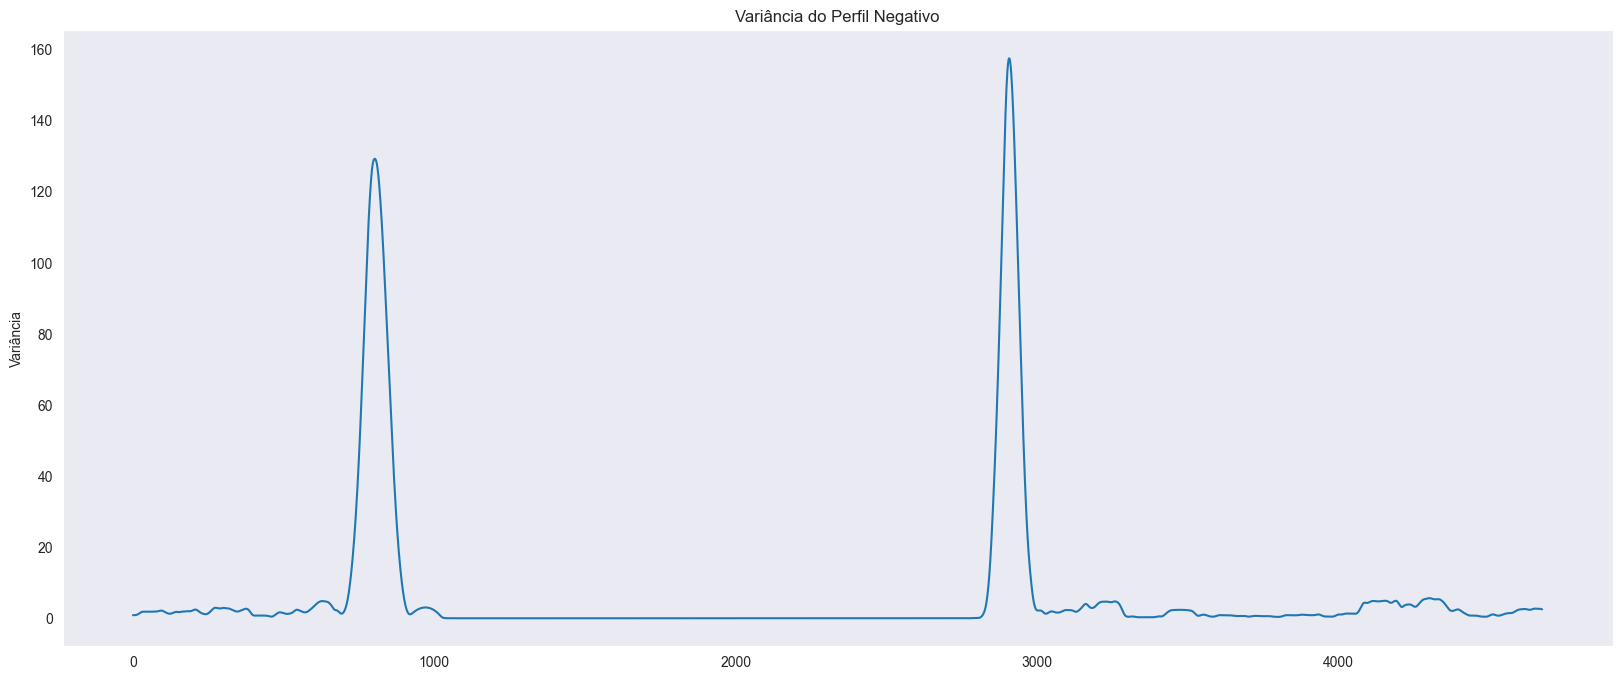

In [20]:
alpha = pd.Series()
altura_var = pd.Series()

for i in range(len(altura)-pontos):
    for j in range(pontos):
        alpha[j] = altura[i+j]
    altura_var[i] = alpha.var()

print(len(altura_var))
ax = sns.lineplot(altura_var)
ax.figure.set_size_inches(20,8)
ax.set_title("Variância do Perfil %s"%Perfil)
ax.set(ylabel = "Variância")
plt.show()

In [21]:
indices_criticos = []


for i in range(len(altura)):
    if i <= 2 or i >= (len(altura) - 3):
        pass
    else:
        s = (altura[i+3] - altura[i-3])
        if (s > 0.5) or (s < -0.5):
            indices_criticos.append(i)

print(indices_criticos)

[15, 16, 17, 18, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 178, 179, 180, 181, 182, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 425, 426, 427, 428, 429, 430, 431, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 46

1321


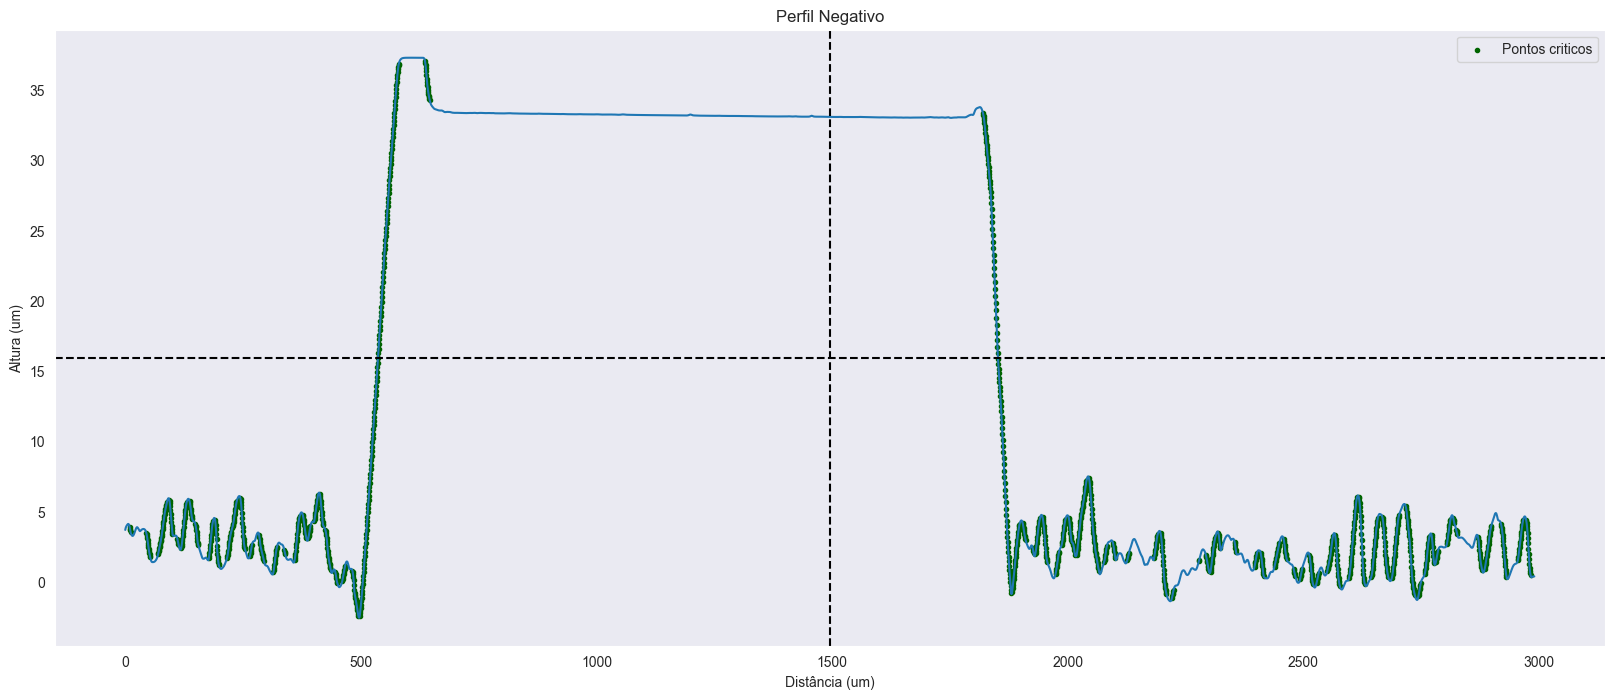

In [22]:
print(len(indices_criticos))

ax = sns.lineplot(y = altura, x = y)
ax.figure.set_size_inches(20,8)
ax.set_title("Perfil %s"%Perfil)
ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")

for i in range(len(indices_criticos)):
    if i == (len(indices_criticos) - 1):
        plt.scatter(x=y[indices_criticos[i]], y = altura[indices_criticos[i]] ,c='darkgreen', s = 9, label = 'Pontos criticos')
    else:    
        plt.scatter(x=y[indices_criticos[i]], y = altura[indices_criticos[i]] ,c='darkgreen', s = 9)
plt.axvline(y.mean(), color = 'black', linestyle = '--')
plt.axhline(altura.mean(), color = 'black', linestyle = '--')
plt.legend(loc = 'upper right')
plt.show()

In [41]:
def AchaMenor(beta, alcance, div):
    m=0
    indice_menor = 0
    
    excluidos = pd.Series()
    for i in range(alcance):
            if beta[i] > altura.mean():
                excluidos[i] = beta[i]
                beta.pop(i)
    beta.reset_index(drop = True, inplace = True)
    
    while m < len(beta)/div:
        if beta[m] < beta[indice_menor]:
            indice_menor = m
        else:
            indice_menor = indice_menor
        m = m + 1

    return (indice_menor + len(excluidos))

In [72]:
if Perfil == 'Negativo':
   alcance_maiores = []
   alcance_menores = []


   for i in range(len(indices_criticos)):
      if y[indices_criticos[i]] > int(y.mean()):
         alcance_maiores.append(i)
      else:
         alcance_menores.append(i)
      
   beta = pd.Series()
   for i in range(len(alcance_maiores)):
      beta[i] = altura[indices_criticos[alcance_maiores[i]]]
   menor = AchaMenor(beta, len(alcance_maiores),3)

   secao5_comeca = indices_criticos[alcance_maiores[menor]]
   secao4_termina = indices_criticos[alcance_maiores[menor]] - 1


   beta = pd.Series()
   for i in range(len(alcance_menores)):
      beta[i] = altura[indices_criticos[alcance_menores[i]]]
      
   menor = AchaMenor(beta,len(alcance_menores),3)
   
   secao1_termina = indices_criticos[alcance_menores[-1*menor]] 
   secao2_comeca = indices_criticos[alcance_menores[-1*menor]] + 1


   secao1_comeca = 0
   secao2_termina = indices_criticos[alcance_menores[-1]]
   secao3_comeca = indices_criticos[alcance_menores[-1]] + 1
   secao3_termina = indices_criticos[alcance_maiores[0]] - 1
   secao4_comeca = indices_criticos[alcance_maiores[0]]
   secao5_termina = len(y)-1

if Perfil == 'Positivo':
   alcance_maiores = []
   alcance_menores = []

   for i in range(len(indices_criticos)):
      if y[indices_criticos[i]] > int(y.mean()):
         alcance_maiores.append(i)
      else:
         alcance_menores.append(i)

   beta = pd.Series()
   for i in range(len(alcance_maiores)):
      beta[i] = altura[indices_criticos[i]]

   menor = AchaMenor(beta, len(alcance_maiores), 3)
   
   secao2_termina = indices_criticos[menor] - 1
   secao3_comeca = indices_criticos[menor]

   beta = pd.Series()
   for i in range(len(alcance_menores)):
      beta[i] = altura[indices_criticos[i]]

   menor = AchaMenor(beta, len(alcance_menores), 3)

   secao3_termina = indices_criticos[-1*menor] - 1
   secao4_comeca = indices_criticos[-1*menor]

   secao1_comeca = 0
   secao1_termina = indices_criticos[0]- 1
   secao2_comeca = indices_criticos[0]
   secao4_termina = indices_criticos[-1] - 1
   secao5_comeca = indices_criticos[-1] 
   secao5_termina = len(y)-1

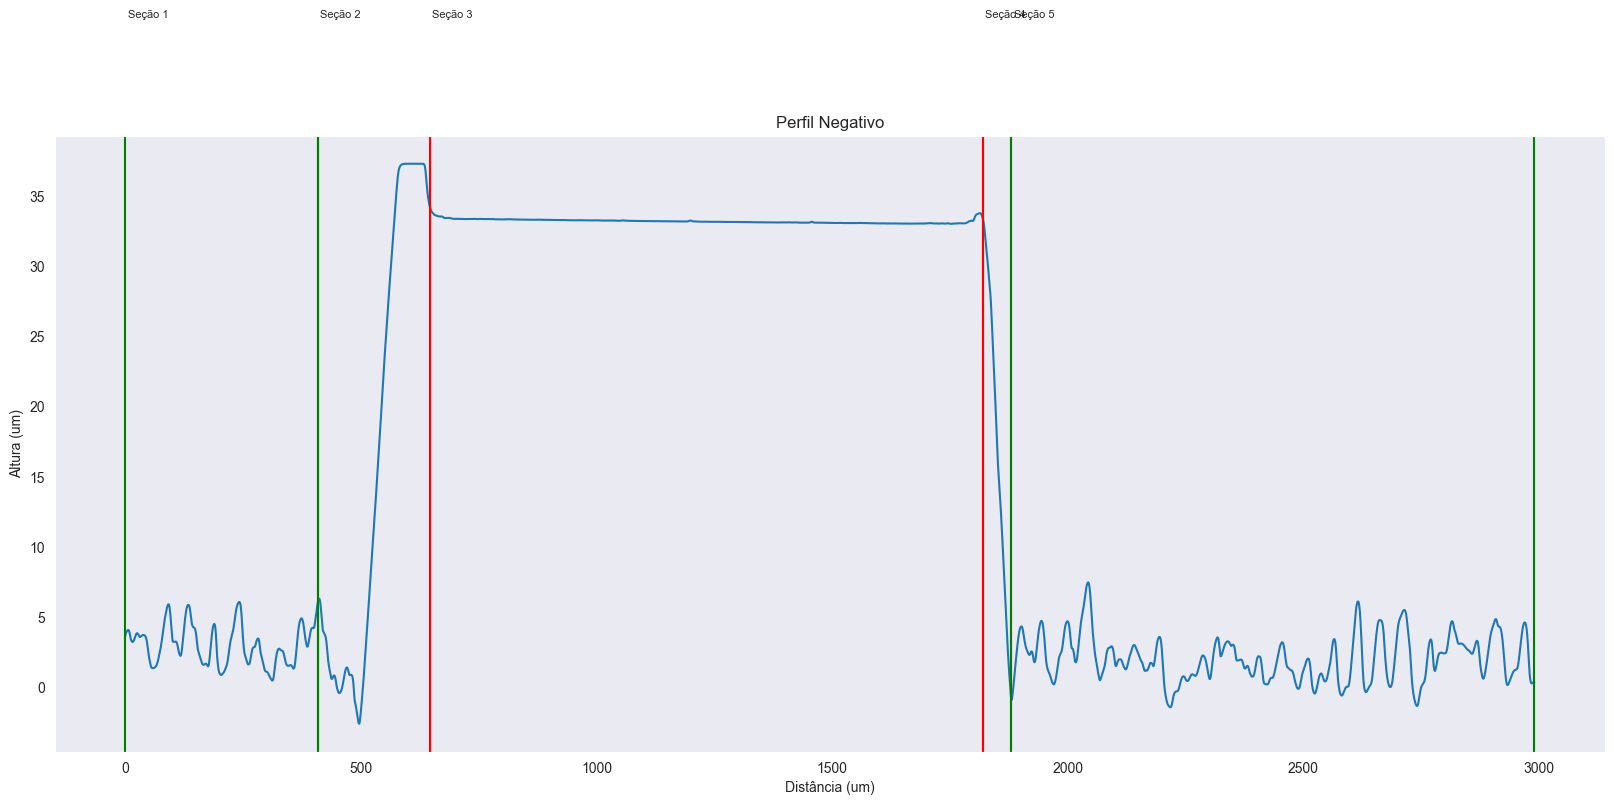

In [73]:
if Perfil == 'Positivo':
    ax = sns.lineplot(y = altura, x = y)

    ax.figure.set_size_inches(20,8)
    ax.set_title("Perfil %s"%Perfil)
    ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")


    plt.axvline(y[secao1_comeca], color = 'r')
    plt.axvline(y[secao1_termina], color = 'r')
    plt.axvline(y[secao2_comeca], color = 'r')
    plt.axvline(y[secao2_termina], color = 'darkgreen')
    plt.axvline(y[secao3_comeca], color = 'darkgreen')
    plt.axvline(y[secao3_termina], color = 'darkgreen')
    plt.axvline(y[secao4_comeca], color = 'darkgreen')
    plt.axvline(y[secao4_termina], color = 'r')
    plt.axvline(y[secao5_comeca], color = 'r')
    plt.axvline(y[secao5_termina], color = 'r')

    plt.text(x = y[secao1_comeca]+5, y = (altura[0]+5), s="Seção 1", fontsize = '8')
    plt.text(x = y[secao2_comeca]+5, y = (altura[0]+5), s="Seção 2", fontsize = '8')
    plt.text(x = y[secao3_comeca]+5, y = (altura[0]+5), s="Seção 3", fontsize = '8')
    plt.text(x = y[secao4_comeca]+5, y = (altura[0]+5), s="Seção 4", fontsize = '8')
    plt.text(x = y[secao5_comeca]+5, y = (altura[0]+5), s="Seção 5", fontsize = '8')
    plt.show()

if Perfil == 'Negativo':
    ax = sns.lineplot(y = altura, x = y)

    ax.figure.set_size_inches(20,8)
    ax.set_title("Perfil %s"%Perfil)
    ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")

    plt.axvline(y[secao1_comeca], color = 'g')
    plt.axvline(y[secao1_termina], color = 'g')
    plt.axvline(y[secao2_comeca], color = 'g')
    plt.axvline(y[secao2_termina], color = 'r')
    plt.axvline(y[secao3_comeca], color = 'r')
    plt.axvline(y[secao3_termina], color = 'r')
    plt.axvline(y[secao4_comeca], color = 'r')
    plt.axvline(y[secao4_termina], color = 'r')
    plt.axvline(y[secao5_comeca], color = 'g')
    plt.axvline(y[secao5_termina], color = 'g')

    plt.text(x = y[secao1_comeca]+5, y = (altura[0]+44), s="Seção 1", fontsize = '8')
    plt.text(x = y[secao2_comeca]+5, y = (altura[0]+44), s="Seção 2", fontsize = '8')
    plt.text(x = y[secao3_comeca]+5, y = (altura[0]+44), s="Seção 3", fontsize = '8')
    plt.text(x = y[secao4_comeca]+5, y = (altura[0]+44), s="Seção 4", fontsize = '8')
    plt.text(x = y[secao5_comeca]+5, y = (altura[0]+44), s="Seção 5", fontsize = '8')
    plt.show()

1048.36875 0.3314552307128906 1048.3688023969105
0.018114795185005986


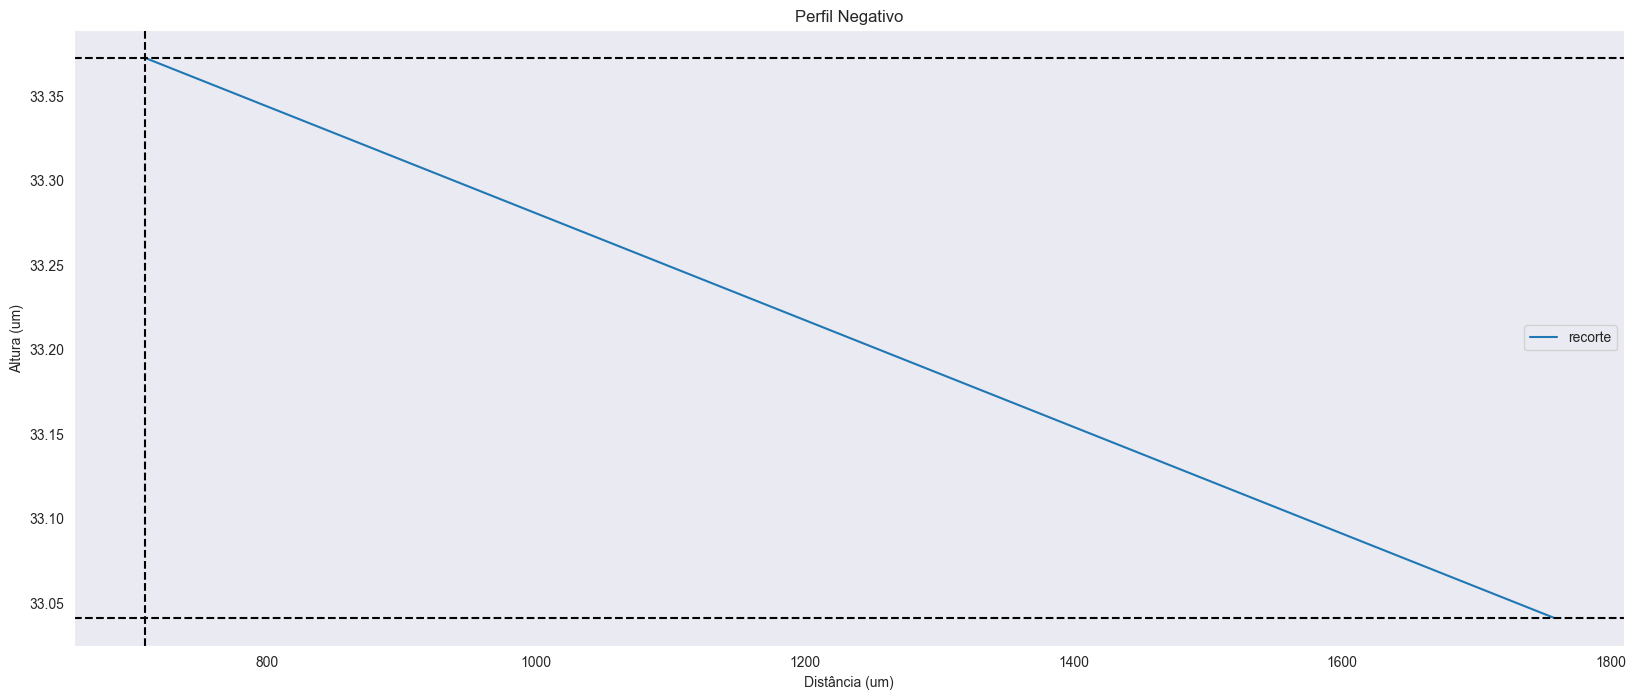

In [140]:
p_x = [float(y[secao3_comeca+100]),float(y[secao3_termina-100])]
p_y = [float(altura[secao3_comeca+100]), float(altura[secao3_termina-100])]

ca = p_x[1] - p_x[0]
co = p_y[0] - p_y[1]
hip = np.sqrt((ca**2)+(co**2))

print(ca, co, hip)

print(np.arcsin(co/hip)*180/np.pi)

#ax = sns.lineplot(y = altura, x = y, label = 'total')
ax = sns.lineplot(x = p_x, y = p_y, label = 'recorte')


ax.figure.set_size_inches(20,8)
ax.set_title("Perfil %s"%Perfil)
ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")



plt.axhline(p_y[0], color = 'black', linestyle = '--')
plt.axhline(p_y[1], color = 'black', linestyle = '--')

plt.axvline(p_x[0], color = 'black', linestyle = '--')


plt.legend()
plt.show()

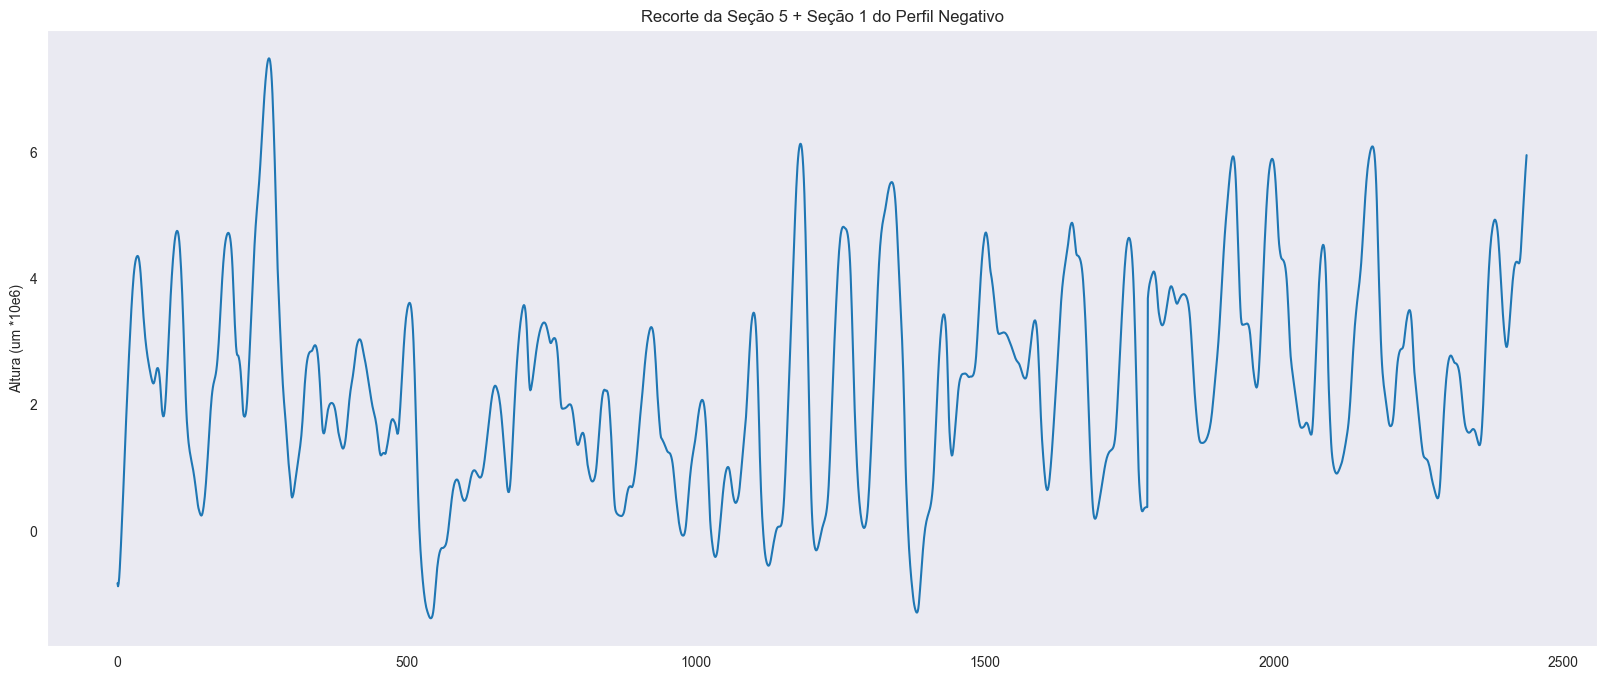

In [26]:
secao1 = pd.Series()
secao2 = pd.Series()
secao3 = pd.Series()
secao4 = pd.Series()
secao5 = pd.Series()

if Perfil == 'Positivo':
    alcance = secao3_termina - secao3_comeca


    for i in range(alcance):
        secao3[i] = altura[i + secao3_comeca]
    linha = secao3
    s = "Seção 3"
    q = linha.quantile(q = 0.95)

if Perfil == 'Negativo':
    alcance = secao1_termina - secao1_comeca
    for i in range(alcance):
        secao1[i] = altura[i + secao1_comeca]
    
    alcance = secao5_termina - secao5_comeca
    for i in range(alcance):
        secao5[i] = altura[i + secao5_comeca]

    linha = pd.concat([secao5, secao1], ignore_index=True)
    s = "Seção 5 + Seção 1"
    q = linha.quantile(q = 0.95)


ax = sns.lineplot(linha)

ax.figure.set_size_inches(20,8)
ax.set_title("Recorte da %s do Perfil %s"%(s, Perfil))
ax.set(ylabel = "Altura (um *10e6)")

plt.show()


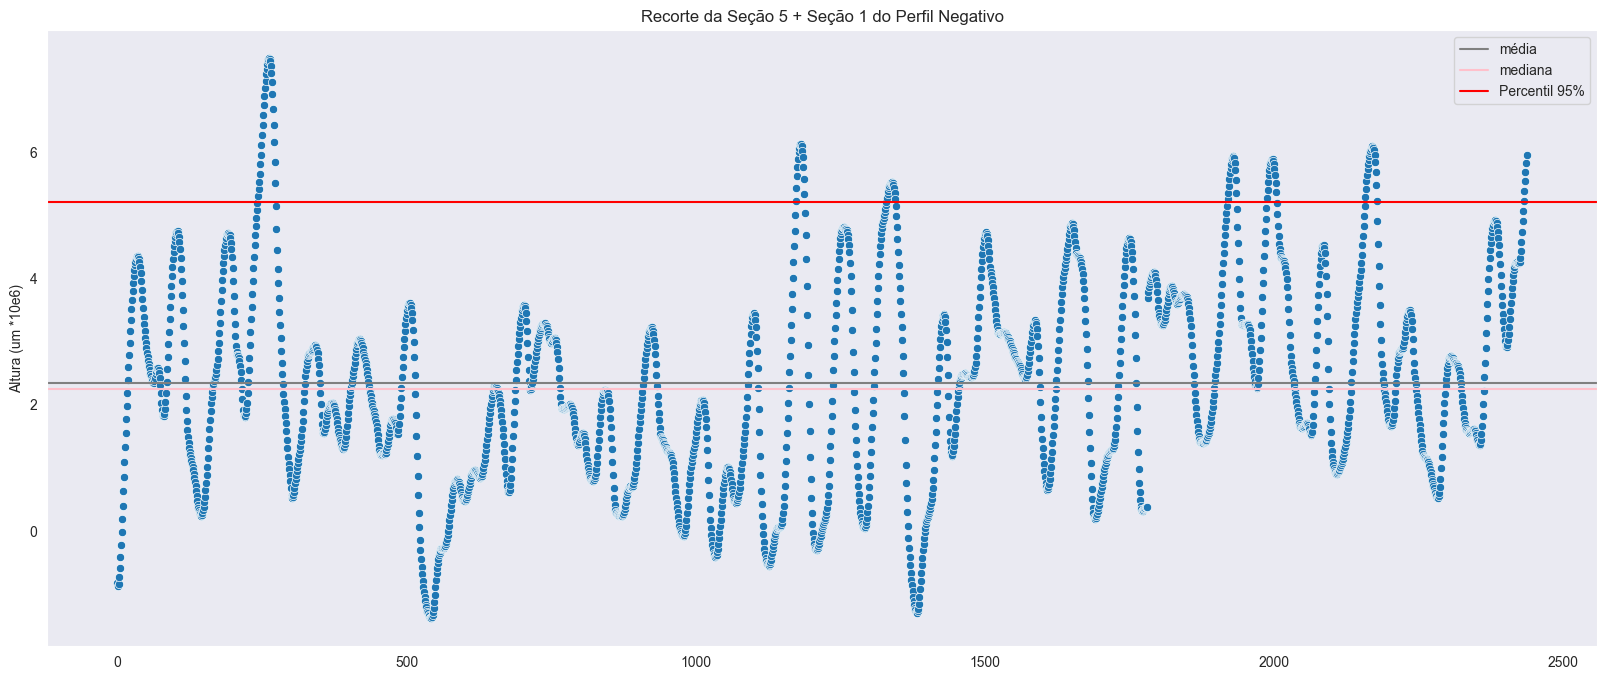

In [27]:
ax = sns.scatterplot(linha)

ax.figure.set_size_inches(20,8)
ax.set_title("Recorte da %s do Perfil %s"%(s, Perfil))
ax.set(ylabel = "Altura (um *10e6)")

plt.plt.axhline(y = linha.mean(),c='gray', label = "média")
plt.plt.axhline(y = linha.median(),c='pink', label = "mediana")
plt.axhline(y = linha.quantile(q = 0.95),c='r', label = "Percentil 95%")

plt.legend(loc = 'upper right')

plt.show()

In [28]:
def ApagaLinha(linha, q, countdown, countup):

    while True:
        if linha[0] > q:
            linha.pop(0)
            countdown -= 1
            linha.reset_index(drop = True, inplace= True)
        else:
            break
    while True:
        if linha[len(linha)-1] > q:
            linha.pop(len(linha)-1)
            countup -= 1
            linha.reset_index(drop = True, inplace= True)
        else:
            break
    
    q_novo = linha.quantile(q=0.95)
    print("saindo")
    return linha,q_novo,countdown, countup

In [29]:
def ReconstroiLinha(inicio, fim, linha, q, countdown, countup):
    p = 0
    aux = pd.Series()
    while True:
        if altura[inicio - 1 + countdown - p] < q:
            aux[0] = altura[inicio - 1 + countup - p]
            linha = pd.concat([aux, linha], ignore_index=True)
        else:
            countdown += p
            p = 0
            
            break
        p += 1  

    while True:
        if altura[fim + 1 - countup + p] < q:
            aux[0] = altura[fim + 1 - countup + p]
            linha = pd.concat([linha, aux], ignore_index=True)
        else:
            countup += p
            p = 0
            break
        p += 1
    return linha, countdown, countup


saindo


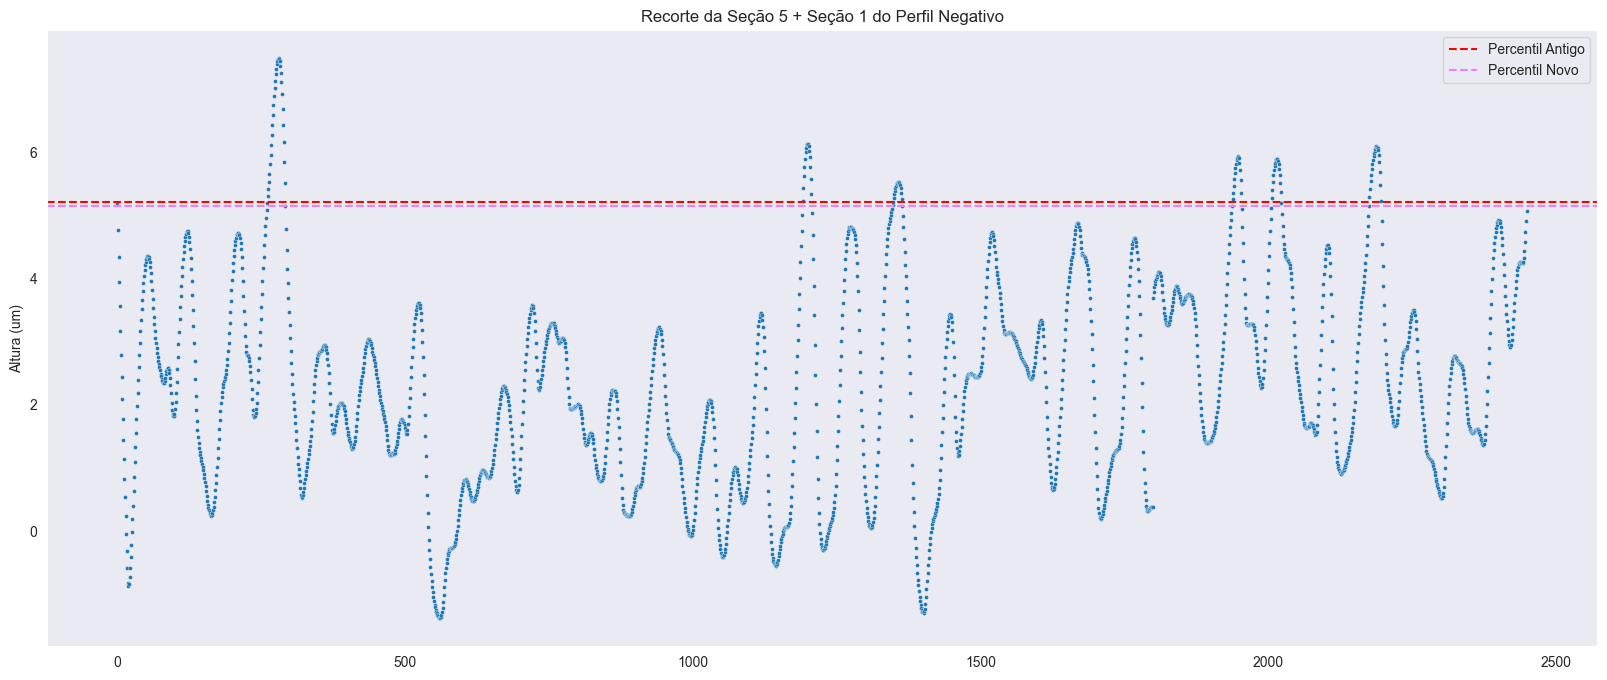

In [30]:
aux = pd.Series()
countdown = 0
countup = 0

if Perfil == 'Positivo':
    inicio = secao3_comeca + countup
    fim = secao3_termina + countdown
elif Perfil == 'Negativo':
    inicio = secao5_comeca + countup
    fim = secao1_termina + countdown



if q != linha.quantile(q=0.95):
    pass
else:
    
    linha, countdown, countup = ReconstroiLinha(inicio, fim, linha, q, countdown, countup)

    linha, q_novo, countdown, countup = ApagaLinha(linha, q, countdown, countup)

    inicio += countup
    fim += countdown

    for i in range(len(linha)):
        if i < 100 or i > len(linha) - 150:
            aux[i] = linha.min()
        else:
            aux[i] = linha[i]
    
    a = 0
    while True:
        
        if (aux.max() < q_novo):
            print("ultimo ajuste...")
            linha, q_novo, countdown, countup = ApagaLinha(linha, q_novo, countdown, countup)
            inicio += countup
            fim += countdown
            a = 1
        if a == 1:
            linha, countdown, countup = ReconstroiLinha(inicio, fim, linha, q_novo, countdown, countup)
        else:
            break

ax = sns.scatterplot(linha, s = 8.5)
ax.figure.set_size_inches(20,8)
ax.set_title("Recorte da %s do Perfil %s"%(s, Perfil))
ax.set(ylabel = "Altura (um)")

plt.axhline(q, color = 'r', linestyle = "--", label = "Percentil Antigo")
plt.axhline(q_novo, color = 'violet',linestyle = "--", label = "Percentil Novo")
plt.legend(loc = 'upper right')

plt.show()

In [31]:
print(countdown)
print(countup)

18
-6
